In [213]:
import os
from pathlib import Path
from typing import Optional, Union, List, Tuple, Literal

import datamol as dm
from rdkit import Chem

from openeye import oechem
from openeye import oequacpac

In [214]:
ligands_path = Path("../examples/Ligands_To_Dock.sdf")

In [215]:
def oe_protonate(smile, kekule=False) -> str:
    """
    Protonate a SMILES string using OpenEye toolkit.
    
    This function takes a SMILES string, converts it to an OpenEye molecule,
    removes salts, adds explicit hydrogens, applies reasonable protonation states,
    and optionally converts to Kekule form before returning the protonated SMILES.
    
    Parameters:
    -----------
    smile : str
        Input SMILES string to be protonated
    kekule : bool, optional
        If True (default), convert aromatic bonds to Kekule form
        
    Returns:
    --------
    str
        Protonated SMILES string
        
    Example:
    --------
    >>> smiles = "C1=CC=C(C=C1)C(=O)O"
    >>> protonated = protonate_smiles(smiles)
    """
    from openeye import oechem
    from openeye import oequacpac

    # Convert SMILES to OpenEye molecule
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, smile)

    # Strip Salt
    oechem.OEDeleteEverythingExceptTheFirstLargestComponent(oemol)

    oechem.OEFindRingAtomsAndBonds(oemol)
    oechem.OEAssignAromaticFlags(oemol, oechem.OEAroModel_OpenEye)
    smiflag = oechem.OESMILESFlag_Canonical
    smiflag |= oechem.OESMILESFlag_ISOMERIC

    oechem.OEAddExplicitHydrogens(oemol)
    oequacpac.OEGetReasonableProtomer(oemol)

    if kekule:
        for bond in oemol.GetBonds(oechem.OEIsAromaticBond()):
            bond.SetIntType(5)
        oechem.OECanonicalOrderAtoms(oemol)
        oechem.OECanonicalOrderBonds(oemol)
        oechem.OEClearAromaticFlags(oemol)
        oechem.OEKekulize(oemol)

    smile = oechem.OECreateSmiString(oemol, smiflag)
    return smile

In [229]:
def cdp_protonate(smiles: str) -> str:
    """
    Takes a SMILES string and returns a protonated SMILES at physiological pH.
    
    Parameters:
    -----------
    smiles : str
        Input SMILES string
        
    Returns:
    --------
    str
        Protonated SMILES string at physiological pH
        
    Raises:
    -------
    Exception
        If SMILES parsing fails or protonation fails
    """
    import CDPL.Chem as Chem

    # Parse the SMILES string to create a molecule object
    mol = Chem.parseSMILES(smiles)
    
    if mol is None:
        raise Exception(f"Failed to parse SMILES: {smiles}")
    
    # Create a BasicMolecule to store the result
    out_mol = Chem.BasicMolecule(mol)
    
    # Prepare the molecule - calculate required properties
    # These are necessary for the protonation algorithm to work correctly
    Chem.calcImplicitHydrogenCounts(out_mol, False)
    Chem.perceiveHybridizationStates(out_mol, False)
    Chem.perceiveSSSR(out_mol, False)  # Smallest Set of Smallest Rings
    Chem.setRingFlags(out_mol, False)
    Chem.setAromaticityFlags(out_mol, False)
    Chem.perceiveComponents(out_mol, False)
    
    # Create and apply the protonation state standardizer
    prot_state_gen = Chem.ProtonationStateStandardizer()
    
    # Apply physiological condition protonation
    prot_state_gen.standardize(out_mol, Chem.ProtonationStateStandardizer.PHYSIOLOGICAL_CONDITION_STATE)
    
    # Update component perception as structure might have changed
    Chem.perceiveComponents(out_mol, True)
    
    # Generate and return the SMILES string
    # Using canonical SMILES for consistency
    return Chem.generateSMILES(out_mol, False, True)  # (molecule, with_stereo, canonical)

In [230]:
def scrubber_protonate(smiles: str) -> str:
    """
    Protonate a SMILES string using the Scrubber library at physiological pH.
    
    This function takes a SMILES string, converts it to an RDKit molecule,
    applies protonation states at pH 7.4 using the Scrubber library,
    and returns the protonated SMILES string without explicit hydrogens.
    
    Parameters:
    -----------
    smiles : str
        Input SMILES string to be protonated
        
    Returns:
    --------
    str
        Protonated SMILES string at physiological pH (7.4) without explicit hydrogens
        
    Notes:
    ------
    - Uses Scrubber library with pH range set to 7.4 (physiological conditions)
    - Removes explicit hydrogens from the final output for cleaner representation
    - Suppresses RDKit logging during the protonation process
    - Returns the first (best) protonated molecule if multiple are generated
    - May raise exceptions if SMILES parsing fails or protonation process encounters errors
    
    Example:
    --------
    >>> smiles = "C1C=CN2C(NC(C)C)=C(CC)N=C2C=1"
    >>> protonated = scrubber_protonate(smiles)
    >>> print(protonated)
    'CCc1nc2ccccn2c1NC(C)C'
    """
    import datamol as dm
    from scrubber import Scrub

    mol = dm.to_mol(smiles)

    scrub = Scrub(
        ph_low=7.4,
        ph_high=7.4,
    )

    with dm.without_rdkit_log():
        prot_mols = list(scrub(mol))
        if len(prot_mols) > 0:
            best_mol = prot_mols[0]
            best_mol_noH = dm.remove_hs(best_mol)

    prot_smiles = dm.to_smiles(best_mol_noH, explicit_hs=False)
    return prot_smiles

In [278]:
def enumerate_stereoisomers(rdmol, use_cip_labeler=False):
    """
    Enumerates stereoisomers for a given RDKit molecule and annotates
    each isomer with its chiral center configurations as a molecular property.

    Args:
        rdmol (rdkit.Chem.rdchem.Mol): The input RDKit molecule.
        use_cip_labeler (bool, optional): If True, uses Chem.rdCIPLabeler.AssignCIPLabels()
                                          to assign CIP labels. Otherwise, relies on
                                          Chem.AssignStereochemistry(). Defaults to False.

    Returns:
        list: A list of RDKit molecule objects, representing the stereoisomers (or the input molecule
              if no new isomers are found), each with a "StereochemistryInfo" property.
              Returns an empty list if the input molecule is None or if enumeration critically fails.
    """
    from rdkit import Chem
    from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
    from rdkit.Chem import rdCIPLabeler

    if not rdmol:
        print("Warning: Input molecule is None.")
        return []

    # Create a copy of the input molecule to work with, ensuring the original is not modified by enumeration.
    mol_to_process = Chem.Mol(rdmol)

    opts = StereoEnumerationOptions(tryEmbedding=False, unique=True, onlyUnassigned=True)
    
    isomers_to_annotate = []

    try:
        # EnumerateStereoisomers returns a tuple of Mol objects.
        # It operates on mol_to_process (the copy).
        enumerated_isomers_tuple = EnumerateStereoisomers(mol_to_process, options=opts)
        
        if not enumerated_isomers_tuple:
            # This means EnumerateStereoisomers returned an empty tuple.
            # This can happen if the molecule has no undefined stereocenters (e.g., achiral or fully defined).
            # User request: "in case it does not find any isomers I would say that return the same molecule."
            # So, we'll process the (copy of the) original input molecule.
            # print(f"Debug: EnumerateStereoisomers returned an empty tuple. Processing the input molecule form: {Chem.MolToSmiles(mol_to_process)}")
            isomers_to_annotate = [mol_to_process] # mol_to_process is already a Mol object (the copy)
        else:
            # Convert non-empty tuple to list for consistent processing.
            isomers_to_annotate = list(enumerated_isomers_tuple)
            # print(f"Debug: EnumerateStereoisomers returned {len(isomers_to_annotate)} isomers.")

    except Exception as e:
        # Per user request, if enumeration itself critically fails, the whole function should fail.
        smiles_for_error = "N/A"
        try:
            smiles_for_error = Chem.MolToSmiles(rdmol) if rdmol else "N/A (rdmol is None)"
        except: # pragma: no cover
            pass # Ignore error in getting SMILES for the error message itself
        print(f"CRITICAL: Stereoisomer enumeration failed for input molecule (SMILES: {smiles_for_error}). Error: {e}")
        return [] # Return empty list to signal critical failure

    # This list will contain:
    # 1. The result of EnumerateStereoisomers if it was successful and non-empty.
    # 2. A list containing mol_to_process (copy of input) if EnumerateStereoisomers returned an empty tuple.
    # 3. It will be empty if a critical error occurred during enumeration.

    if not isomers_to_annotate: # Should only be true if critical error happened and returned [] above.
        return []

    annotated_isomers_list = []
    for i, current_isomer_mol in enumerate(isomers_to_annotate):
        # current_isomer_mol is an element from isomers_to_annotate.
        # It's either a newly generated Mol object from enumeration or mol_to_process.
        # We can directly annotate it.
        
        Chem.AssignStereochemistry(current_isomer_mol, cleanIt=True, force=True, flagPossibleStereoCenters=True)

        if use_cip_labeler:
            try:
                rdCIPLabeler.AssignCIPLabels(current_isomer_mol)
            except Exception as e: # pragma: no cover
                # Continue processing even if CIP labeling fails for one isomer, but log it.
                print(f"Warning: Error assigning CIP labels for isomer {i} (SMILES: {Chem.MolToSmiles(current_isomer_mol)}): {e}")
        
        chiral_centers = Chem.FindMolChiralCenters(current_isomer_mol, includeUnassigned=True)

        stereo_info_parts = []
        if chiral_centers:
            for atom_idx, chirality_tag in chiral_centers:
                atom = current_isomer_mol.GetAtomWithIdx(atom_idx)
                atom_symbol = atom.GetSymbol()
                stereo_info_parts.append(f"Atom {atom_idx} ({atom_symbol}): {chirality_tag}")
        
        if stereo_info_parts:
            current_isomer_mol.SetProp("STEREO", "; ".join(stereo_info_parts))
        else:
            current_isomer_mol.SetProp("STEREO", "No assignable chiral centers found or molecule is achiral.")
        
        annotated_isomers_list.append(current_isomer_mol)

    return annotated_isomers_list

In [351]:
def get_best_tautomer(mol: Chem.rdchem.Mol, score_threshold: Optional[float] = None) -> Union[Chem.rdchem.Mol, List[Chem.rdchem.Mol]]:
    """
    Find and return the best tautomer(s) of a given molecule based on RDKit's scoring system.
    
    This function enumerates all possible tautomers of the input molecule and selects
    the one with the highest score. If score_threshold is provided and multiple tautomers 
    have similar scores (within the threshold), it returns all of them as a list.
    
    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        Input RDKit molecule object for which to find the best tautomer(s)
    score_threshold : Optional[float], optional
        Score difference threshold for considering tautomers as similar. 
        If None (default), returns only the single best tautomer.
        If provided, returns all tautomers within ±score_threshold of the best as a list.
        
    Returns:
    --------
    Union[rdkit.Chem.rdchem.Mol, List[rdkit.Chem.rdchem.Mol]]
        If score_threshold is None: Single RDKit molecule object representing the best tautomer.
        If score_threshold is provided: List of RDKit molecule objects representing the best tautomer(s).
        Returns None (single mode) or empty list (list mode) if no tautomers are found.
        
    Notes:
    ------
    - Uses RDKit's TautomerEnumerator with custom parameters
    - Preserves Sp3 stereochemistry, bond stereochemistry, and isotopic hydrogens
    - Maximum of 1000 tautomers are enumerated
    - Higher scores indicate more favorable tautomers
    - In single mode (score_threshold=None), returns the highest scoring tautomer
    - In list mode (score_threshold provided), returns all tautomers within ±score_threshold of the best
    
    Example:
    --------
    >>> mol = Chem.MolFromSmiles("N1C=C(C2CC2)C(=O)NC1=O")
    >>> best_taut = get_best_tautomer(mol)  # Returns single molecule
    >>> best_tauts = get_best_tautomer(mol, score_threshold=1.0)  # Returns list
    """
    from rdkit.Chem.MolStandardize import rdMolStandardize
    
    params = rdMolStandardize.CleanupParameters()
    params.maxTautomers = 1000
    params.tautomerRemoveSp3Stereo = False      # Preserve stereochemistry
    params.tautomerRemoveBondStereo = False     # Preserve E/Z stereochemistry
    params.tautomerRemoveIsotopicHs = False     # Preserve isotopic hydrogens

    enumerator = rdMolStandardize.TautomerEnumerator(params)
    tautomers = list(enumerator.Enumerate(mol))

    if len(tautomers) == 0:
        print("No tautomers found for the input molecule.")
        return [] if score_threshold is not None else None
    
    # Score all tautomers and find the best score
    scored_tautomers = []
    best_score = -float('inf')
    
    for taut in tautomers:
        score = enumerator.ScoreTautomer(taut)
        scored_tautomers.append((taut, score))
        if score > best_score:
            best_score = score
    
    if score_threshold is None:
        # Return only the single best tautomer
        for taut, score in scored_tautomers:
            if score == best_score:
                taut.SetProp("TautomerScore", str(score))
                return taut
    else:
        # Return all tautomers within the threshold as a list
        selected_tautomers = []
        for taut, score in scored_tautomers:
            print(f"Tautomer: {Chem.MolToSmiles(taut)}, Score: {score}")
            if abs(score - best_score) <= score_threshold:
                # Add score as molecular property
                taut.SetProp("TautomerScore", str(score))
                selected_tautomers.append(taut)
        
        return selected_tautomers

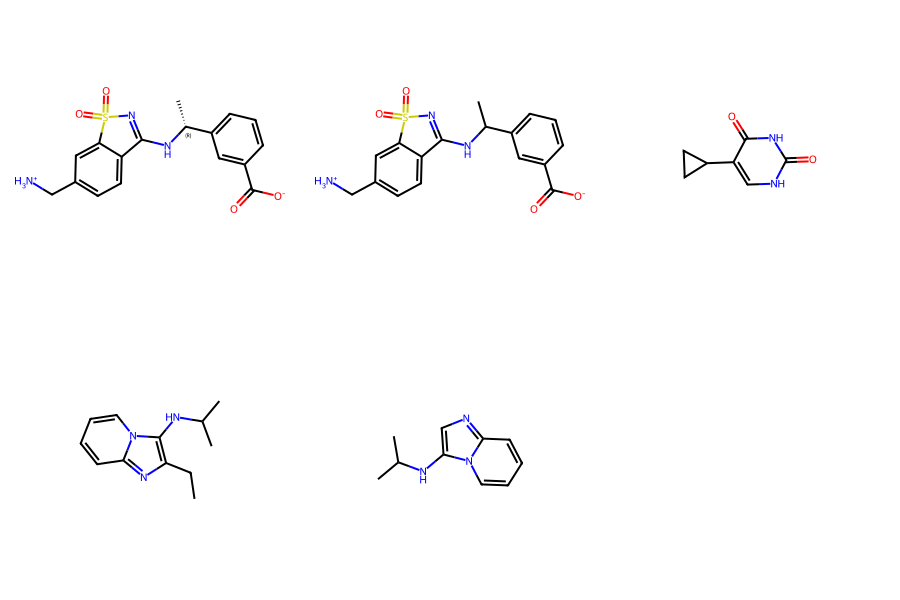

In [352]:
smiles_to_test = [
    "C1C(C[NH3+])=CC2=C(C(N[C@@H](C3C=CC=C(C(=O)[O-])C=3)C)=NS2(=O)=O)C=1",
    "C1C(C[NH3+])=CC2=C(C(NC(C3C=CC=C(C(=O)[O-])C=3)C)=NS2(=O)=O)C=1",
    "N1C=C(C2CC2)C(=O)NC1=O",
    "C1C=CN2C(NC(C)C)=C(CC)N=C2C=1",
    "C1C=CN2C(NC(C)C)=CN=C2C=1",
]

dm.to_image([dm.to_mol(smile) for smile in smiles_to_test], mol_size=(300, 300), n_cols=3)

In [353]:
def prepare_ligand_pipeline(smiles, protonation_method: callable):
    
    protonated_smiles = protonation_method(smiles)
    stereo_mols = enumerate_stereoisomers(dm.to_mol(protonated_smiles), use_cip_labeler=True)

    tauto_mols = []
    for stereo_mol in stereo_mols:
        best_taut = get_best_tautomer(stereo_mol)
        tauto_mols.append(best_taut)

    return tauto_mols

In [354]:
get_best_tautomer(dm.to_mol(smiles_to_test[2]), score_threshold=2)

Tautomer: O=C1N=C(O)N=CC1C1CC1, Score: 11
Tautomer: O=C1N=CC(C2CC2)C(=O)N1, Score: 13
Tautomer: O=C1N=CC(C2CC2)C(O)=N1, Score: 11
Tautomer: O=c1[nH]c(O)ncc1C1CC1, Score: 102
Tautomer: O=c1[nH]cc(C2CC2)c(=O)[nH]1, Score: 104
Tautomer: O=c1nc(O)[nH]cc1C1CC1, Score: 102
Tautomer: O=c1nc(O)c(C2CC2)c[nH]1, Score: 102
Tautomer: O=c1ncc(C2CC2)c(O)[nH]1, Score: 102
Tautomer: Oc1ncc(C2CC2)c(O)n1, Score: 100


Tautomer: O=C1N=C(O)N=CC1C1CC1, Score: 11
Tautomer: O=C1N=CC(C2CC2)C(=O)N1, Score: 13
Tautomer: O=C1N=CC(C2CC2)C(O)=N1, Score: 11
Tautomer: O=c1[nH]c(O)ncc1C1CC1, Score: 102
Tautomer: O=c1[nH]cc(C2CC2)c(=O)[nH]1, Score: 104
Tautomer: O=c1nc(O)[nH]cc1C1CC1, Score: 102
Tautomer: O=c1nc(O)c(C2CC2)c[nH]1, Score: 102
Tautomer: O=c1ncc(C2CC2)c(O)[nH]1, Score: 102
Tautomer: Oc1ncc(C2CC2)c(O)n1, Score: 100


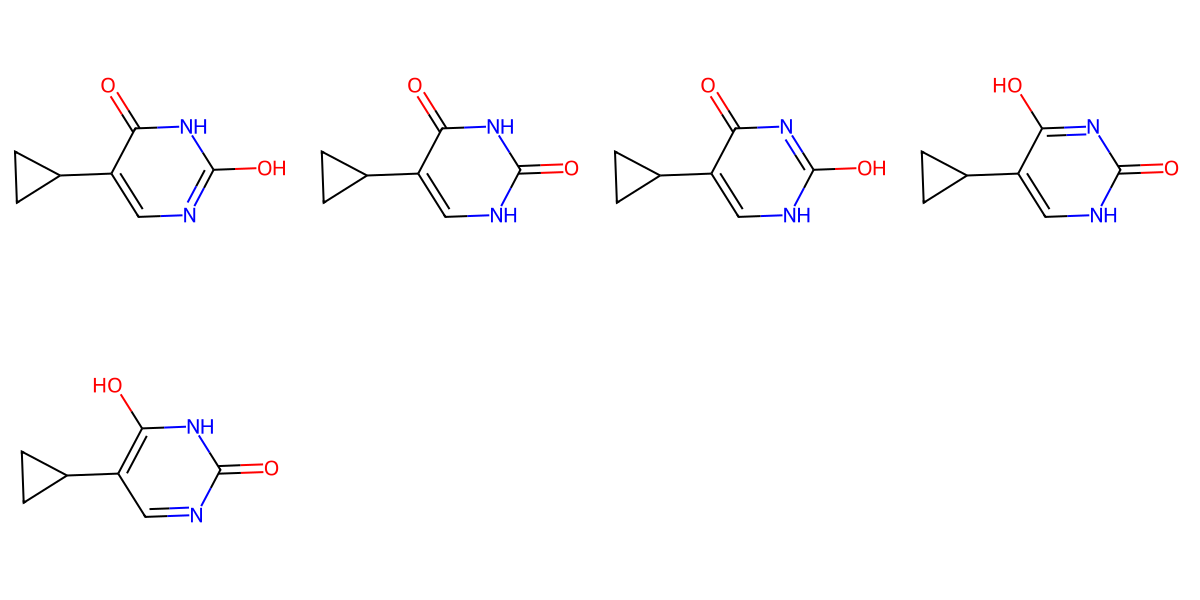

In [355]:
dm.to_image(get_best_tautomer(dm.to_mol(smiles_to_test[2]), score_threshold=2))